# Programa de Pós-Graduação em Computação Aplicada (UnB)
## Disciplina: ANÁLISE ESTATÍSTICA DE DADOS E INFORMAÇÕES - Turma 01 - 2023/1
## Professor: João Gabriel de Moraes Souza
## Aluno: Francisco Gonçalves de Araújo Filho
## Matrícula: 231109675
### Tarefa 5

A Tarefa irá se basear na aplicação prática de um problema de Ciência de Dados em Machine Learning. Esses problemas são originados de dados reais aplicados em problemas de Negócio. A Tarefa do 5 irá abordar a aplicação do problema Retenção de Clientes de Unidades Bancárias. Esse problema trata-se do objetivo de encontrar um modelo que seja capaz de prever se os indivíduos se mantiveram ou não clientes dos bancos. Com esses dados a Tarefa 5 pede:

### Questão a) Realize a previsão por um modelo de Regressão Logística.

### Preparação dos Dados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# pd.options.display.max_rows = None
# pd.options.display.max_columns = None

_debug = False

In [2]:
# Leitura dos dados em um Data frame
df = pd.read_csv('Churn_Modelling.csv', delimiter=',')
df.shape

(10000, 14)

In [3]:
# Vefifica a lista de colunas e valores
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

#### Retirando colunas sem necessidade

In [4]:
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

In [5]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Análise dos dados:
Com base no exposto acima, algumas questões não tem respostas:
- Os dados parecem ser uma fotografia em um determinado momento no tempo, por exemplo, o saldo é para uma determinada data, o que gera dúvidas:
    - Qual é a data e qual é a relevância dessa data?
    - Seria possível obter saldos ao longo de um período de tempo em vez de uma única data?
- Existem clientes que saíram, mas ainda possuem saldo em suas contas! O que isso poderia significar? Eles poderiam ter saído de um produto, mas não do banco?
- O que significa ser um membro ativo e existem diferentes graus disso? Seria melhor fornecer a contagem de transações em termos de créditos e débitos na conta?
- Uma análise detalhada dos produtos adquiridos por um cliente poderia fornecer mais informações além da simples contagem de produtos.

In [6]:
# Checando os tipos das variáveis
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

### Análise Exploratória de Dados (Exploratory Data Analysis, EDA)
O principal interesse no problema é compreender como as variáveis condicionais fornecidas se relacionam com o status da variável de interesse *'Exited'*, relativa a retenção ou abandono de clientes em unidades bancárias.

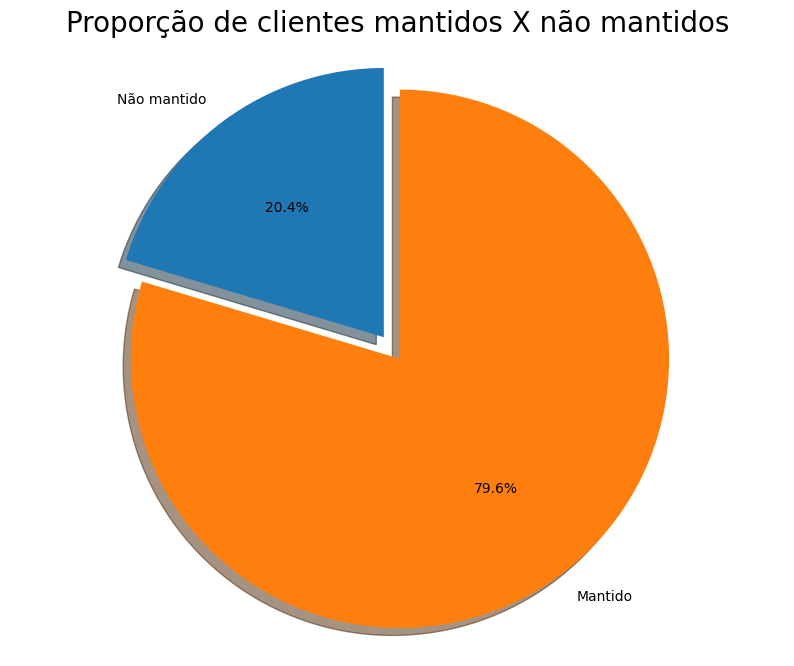

In [7]:
labels = 'Não mantido', 'Mantido'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proporção de clientes mantidos X não mantidos", size = 20)
plt.show()

#### Análise da relação:
Cerca de 20% dos clientes saíram. Portanto, o modelo de referência deverá prever que 20% dos clientes irão sair. Como 20% é um número pequeno, é necessário garantir que o modelo escolhido preveja com grande precisão esses 20%, pois é do interesse do banco identificar e reter esse grupo, em vez de prever com precisão os clientes que são retidos.

<Axes: xlabel='IsActiveMember', ylabel='count'>

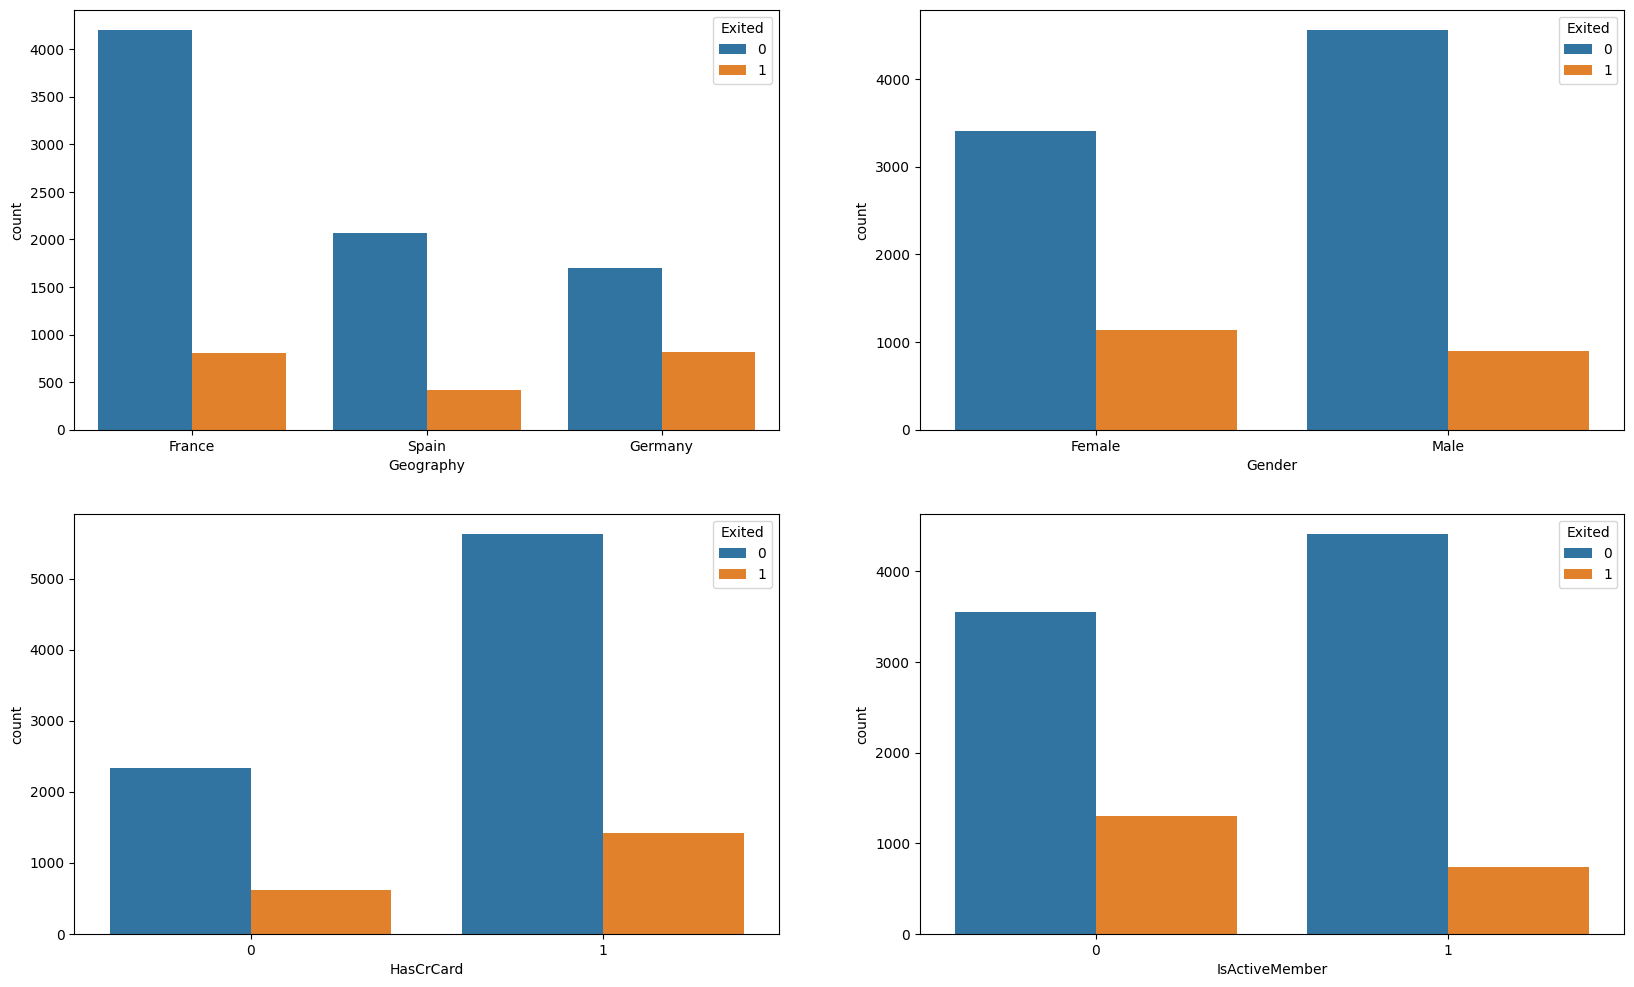

In [8]:
# Revisão da relação entre a variável de interesse e as variáveis categóricas, que atribuiem categorias.
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

#### Análise das relações entre 'status' e as variáveis categóricas:
- A maioria dos dados é de pessoas da França. No entanto, a proporção de clientes que saíram é inversamente relacionada à população de clientes, o que sugere que o banco possa ter um problema (possivelmente falta de recursos de atendimento ao cliente) nas áreas onde tem menos clientes.
- A proporção de clientes do sexo feminino que saíram também é maior do que a dos clientes do sexo masculino.
- A maioria dos clientes que saíram são aqueles com cartões de crédito. Dado que a maioria dos clientes possui cartões de crédito.
- Os membros inativos têm uma taxa de saída maior. Preocupante é que a proporção geral de membros inativos é bastante alta, o que sugere que o banco pode precisar implementar um programa para converter esse grupo em clientes ativos, pois isso certamente terá um impacto positivo na retenção de clientes.

<Axes: xlabel='Exited', ylabel='EstimatedSalary'>

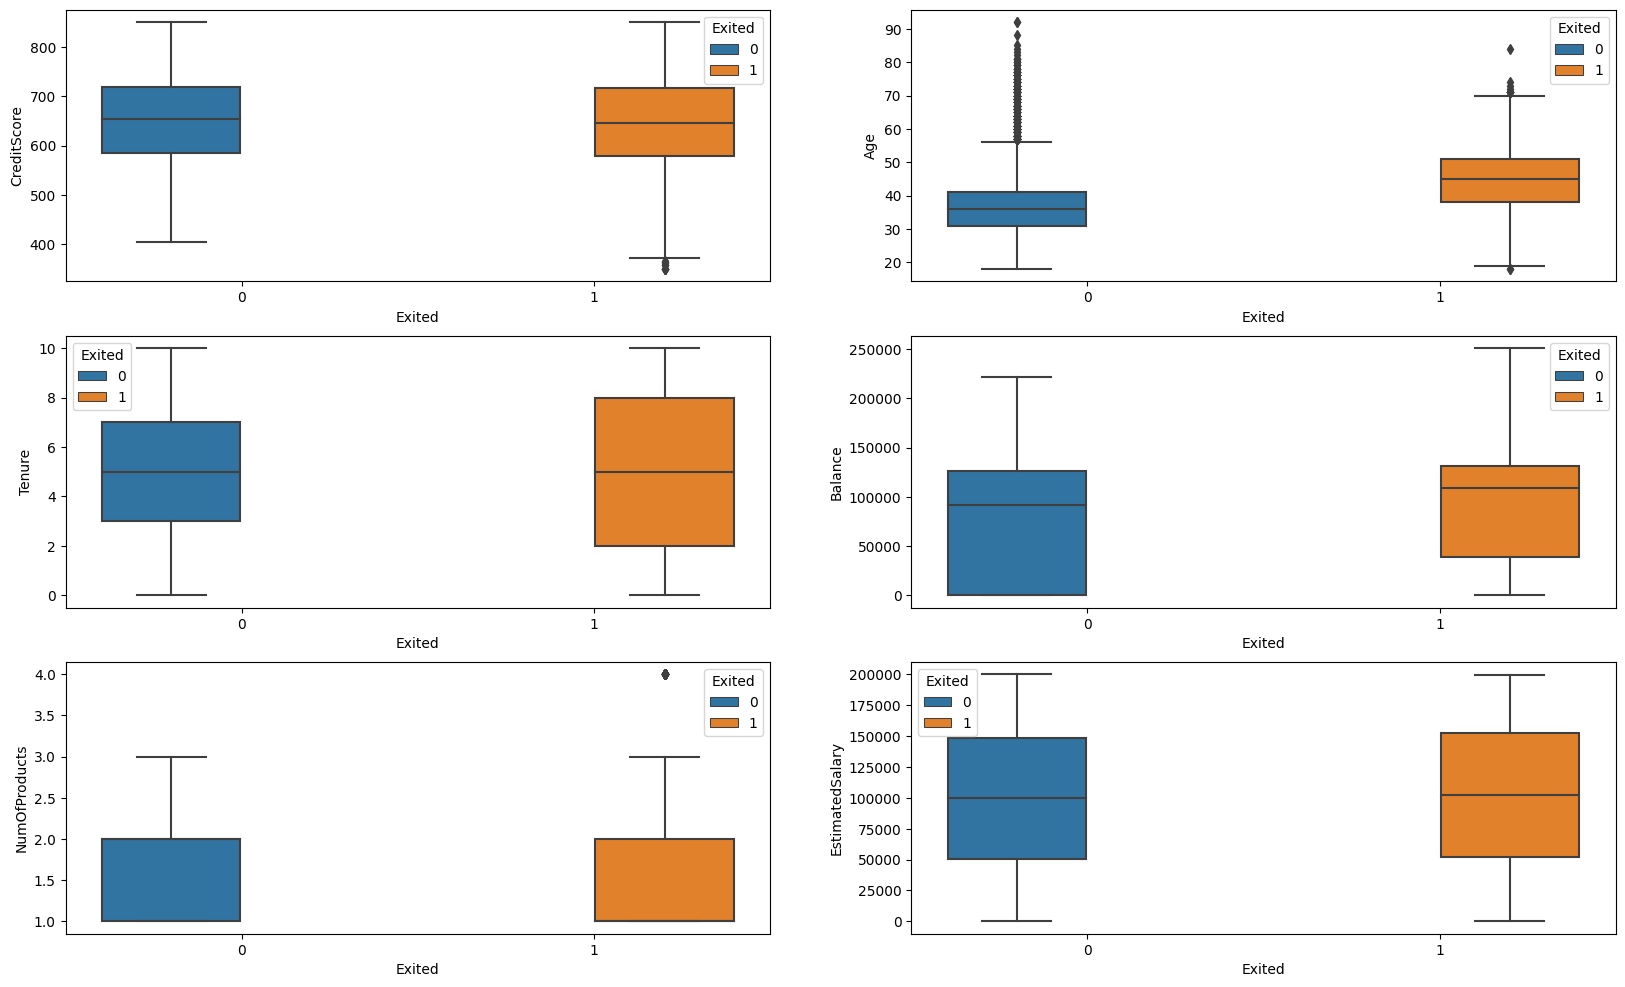

In [9]:
# Revisão da relação entre a variável de interesse e as variáveis contínuas.
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

#### Análise das relações a variável de interesse e as variáveis contínuas:
- Não há diferença significativa na distribuição do score de crédito entre os clientes mantidos e os que saíram.
- Os clientes mais velhos têm uma taxa de saída maior em comparação aos mais jovens, sugerindo que a unidade bancária revise seu mercado-alvo ou sua estratégia de retenção entre os diferentes grupos etários.
- Em relação ao tempo de permanência (tenure), os clientes nos extremos (que passaram pouco tempo ou muito tempo com o banco) têm maior probabilidade de sair em comparação com aqueles que têm um tempo médio de permanência.
- O banco está perdendo clientes com saldos significativos, o que pode afetar seu capital disponível.
- Nem o produto nem o salário têm um efeito significativo na probabilidade de saída.

### 4. Feature engineering


In [10]:
# Cria nova variável da relação entre saldo bancário e salário estimado
# df['BalanceSalaryRatio'] = df.Balance/df.EstimatedSalary
# sns.boxplot(y='BalanceSalaryRatio',x = 'Exited', hue = 'Exited',data = df)
# plt.ylim(-1, 5)

#### Análise da relação da taxa Saldo/Salário e a variável de interesse:
Foi observado anteriormete que o salário tem pouco efeito na probabilidade de um cliente sair. No entanto, como no gráfico acima, a taxa criada do saldo bancário em relação ao salário estimado indica que os clientes com uma proporção mais alta têm maior probabilidade de sair, o que seria preocupante para o banco, pois isso afeta sua fonte de capital.

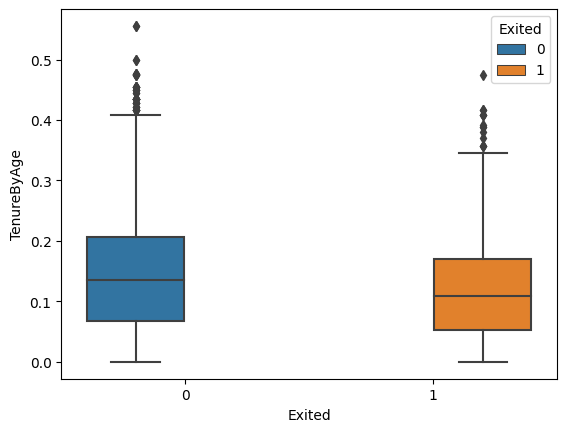

In [11]:
# Foi acrescida uma variável com o objetivo de padronizar o tempo de permanência em relação à idade:
df['TenureByAge'] = df.Tenure/(df.Age)
sns.boxplot(y='TenureByAge',x = 'Exited', hue = 'Exited',data = df)
#plt.ylim(-1, 1)
plt.show()

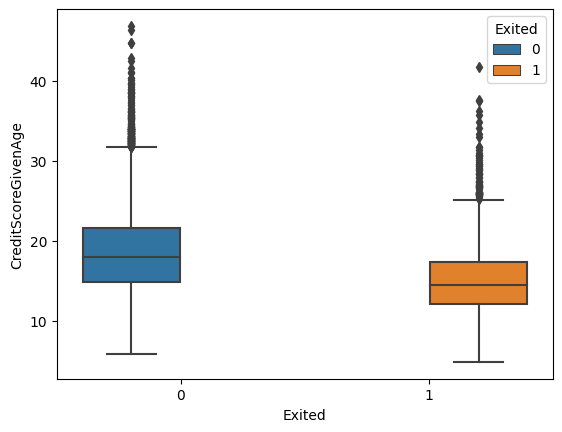

In [12]:
# A última variável inserida tem o objetivo de capturar o score de crédito em relação à idade, 
# a fim de levar em consideração o comportamento de crédito ao longo da vida adulta.
df['CreditScoreGivenAge'] = df.CreditScore/(df.Age)
sns.boxplot(y='CreditScoreGivenAge',x = 'Exited', hue = 'Exited',data = df)
# plt.ylim(-1, 1)
plt.show()

In [13]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,TenureByAge,CreditScoreGivenAge
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.047619,14.738095
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.024390,14.829268
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0.190476,11.952381
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.025641,17.923077
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0.046512,19.767442


### Preparando o dado para o Treinamento do Modelo

#### As seguintes operação são feitas a seguir:
- **Organização a ordem das colunas por tipo de dados**:
    1. Variável de interesse;
    2. Variáveis contínuas;
    3. Variáveis categóricas (discretas).
- **Aplicação da *codificação simétrica* para variáveis binárias**:  Para as variáveis 0 ou 1, foi alterado o valor 0 para -1, para que os modelos possam capturar uma relação negativa 
quando o atributo for inaplicável, para realizar uma simetria na influência da variável;
- **Aplicação do formato *on-hot* e *codificação simétrica*** para as demais variáveis categóricas.
- **Normalicação das variáveis contínuas usando a escala *Min/Max***

In [14]:
# Rearranjando as colunas por tipo de dado
continuous_vars = ['CreditScore',  'Age', 'Tenure', 'Balance','NumOfProducts', 
                   'EstimatedSalary',	'TenureByAge',	'CreditScoreGivenAge']
cat_vars = ['HasCrCard', 'IsActiveMember','Geography', 'Gender']
df = df[['Exited'] + continuous_vars + cat_vars]
df.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography,Gender
0,1,619,42,2,0.00,1,101348.88,0.047619,14.738095,1,1,France,Female
1,0,608,41,1,83807.86,1,112542.58,0.024390,14.829268,0,1,Spain,Female
2,1,502,42,8,159660.80,3,113931.57,0.190476,11.952381,1,0,France,Female
3,0,699,39,1,0.00,2,93826.63,0.025641,17.923077,0,0,France,Female
4,0,850,43,2,125510.82,1,79084.10,0.046512,19.767442,1,1,Spain,Female


In [15]:
# Aplicando codificação simétrica para variáveis booleanas
# df.loc[df.HasCrCard == 0, 'HasCrCard'] = -1
# df.loc[df.IsActiveMember == 0, 'IsActiveMember'] = -1
# df.head()

In [16]:
# usando formato "one-hot" para as demais variáveis categóricas
lst = ['Geography', 'Gender']
remove = list()
for i in lst:
    if (df[i].dtype == str or df[i].dtype == object):
        for j in df[i].unique():
            df[i+'_'+j] = np.where(df[i] == j,1,0)
        remove.append(i)
df = df.drop(remove, axis=1)
df.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography_France,Geography_Spain,Geography_Germany,Gender_Female,Gender_Male
0,1,619,42,2,0.00,1,101348.88,0.047619,14.738095,1,1,1,0,0,1,0
1,0,608,41,1,83807.86,1,112542.58,0.024390,14.829268,0,1,0,1,0,1,0
2,1,502,42,8,159660.80,3,113931.57,0.190476,11.952381,1,0,1,0,0,1,0
3,0,699,39,1,0.00,2,93826.63,0.025641,17.923077,0,0,1,0,0,1,0
4,0,850,43,2,125510.82,1,79084.10,0.046512,19.767442,1,1,0,1,0,1,0


In [17]:
# Normalizando as variáveis continuas usando a escala minMax
minVec = df[continuous_vars].min().copy()
maxVec = df[continuous_vars].max().copy()
df[continuous_vars] = (df[continuous_vars]-minVec)/(maxVec-minVec)
df.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography_France,Geography_Spain,Geography_Germany,Gender_Female,Gender_Male
0,1,0.538,0.324324,0.2,0.000000,0.000000,0.506735,0.085714,0.235083,1,1,1,0,0,1,0
1,0,0.516,0.310811,0.1,0.334031,0.000000,0.562709,0.043902,0.237252,0,1,0,1,0,1,0
2,1,0.304,0.324324,0.8,0.636357,0.666667,0.569654,0.342857,0.168807,1,0,1,0,0,1,0
3,0,0.698,0.283784,0.1,0.000000,0.333333,0.469120,0.046154,0.310859,0,0,1,0,0,1,0
4,0,1.000,0.337838,0.2,0.500246,0.000000,0.395400,0.083721,0.354739,1,1,0,1,0,1,0


#### Rebalanceando o banco de dados
Nesse passo aplicaremos o algorítmo SMOTE (Synthetic Minority Oversampling Technique) de balanceamento das amostras de treinamento.

O algoritmo SMOTE (Synthetic Minority Over-sampling Technique) é uma técnica de balanceamento de classes utilizada em problemas de aprendizado de máquina quando há desequilíbrio entre as classes do conjunto de dados. O desequilíbrio de classes ocorre quando uma classe tem um número significativamente menor de exemplos em relação a outras classes.

In [18]:
# df_train = df.sample(frac=0.8,random_state=200)
# df_test = df.drop(df_train.index)
col_y = 'Exited'
X = df.loc[:, df.columns != col_y]
y = df.loc[:, df.columns == col_y]
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=[col_y])
# we can Check the numbers of our data
print("Tamanho do oversampled é: ",len(os_data_X))
print("Número de não aderência:",len(os_data_y[os_data_y[col_y]==0]))
print("Número de aderência:",len(os_data_y[os_data_y[col_y]==1]))
print("Proporção de não aderência: ",len(os_data_y[os_data_y[col_y]==0])/len(os_data_X)*100, "%")
print("Proporção de aderência:", len(os_data_y[os_data_y[col_y]==1])/len(os_data_X)*100, "%")

Tamanho do oversampled é:  11168
Número de não aderência: 5584
Número de aderência: 5584
Proporção de não aderência:  50.0 %
Proporção de aderência: 50.0 %


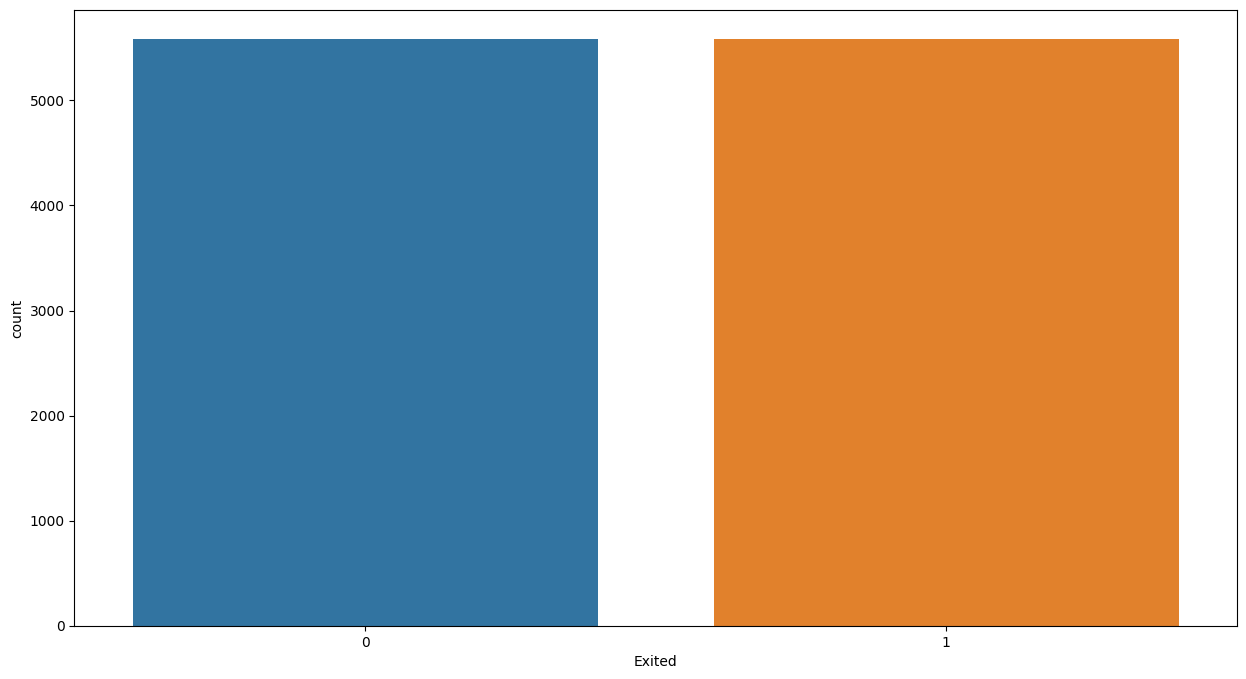

In [19]:
plt.figure(figsize=(15,8))
figure = sns.countplot(x=col_y, data = os_data_y)

In [20]:
# Separa cojunto de amostra de treinamento
X=os_data_X.loc[:, os_data_X.columns != col_y]
y=os_data_y[col_y]
# Separa cojunto de amostra de teste
y_t = y_test.Exited
X_t = X_test.loc[:, X_test.columns != col_y]

#### Seleção de Variáveis via LOGIT
Recursive Feature Elimination (RFE) é baseada na ideia de repetidamente construir um modelo e selecionar as variáveis que apresentam as melhores e as piores performance. O processo é repetido recursivamente até que sejam selecionadas as variáveis que mais importam para o modelo, de modo a ficar com um número parcimonioso de variáveis.

In [21]:
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=13)
rfe = rfe.fit(X, y)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True False  True  True False  True  True  True
  True  True  True]
[1 1 1 1 1 3 1 1 2 1 1 1 1 1 1]


In [22]:
os_data_X.columns.values

array(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary', 'TenureByAge', 'CreditScoreGivenAge',
       'HasCrCard', 'IsActiveMember', 'Geography_France',
       'Geography_Spain', 'Geography_Germany', 'Gender_Female',
       'Gender_Male'], dtype=object)

In [23]:
# Retira colunas Eliminadas pelo RFE
cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
        'TenureByAge', 'CreditScoreGivenAge',
        'IsActiveMember', 'Geography_France',
        'Geography_Spain', 'Geography_Germany', 'Gender_Female',
        'Gender_Male']
df_temp = os_data_X[cols]
# Reatribuindo X e y com colunas retiradas
X=os_data_X[cols]
y=os_data_y[col_y]

#### Implementando o LOGIT

In [24]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.562160
         Iterations 8
                           Results: Logit
Model:                Logit             Method:            MLE       
Dependent Variable:   Exited            Pseudo R-squared:  0.189     
Date:                 2023-06-16 12:33  AIC:               12580.4133
No. Observations:     11168             BIC:               12668.2630
Df Model:             11                Log-Likelihood:    -6278.2   
Df Residuals:         11156             LL-Null:           -7741.1   
Converged:            1.0000            LLR p-value:       0.0000    
No. Iterations:       8.0000            Scale:             1.0000    
---------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025   0.975]
---------------------------------------------------------------------
CreditScore          2.5545   0.2856   8.9444 0.0000   1.9947  3.1142
Age             

In [25]:
log_odds = result.params.values
pd.DataFrame(log_odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
CreditScore,2.554471
Gender_Female,1.397860
Geography_Germany,1.247299
Gender_Male,0.773978
TenureByAge,0.646876
Balance,0.523904
Geography_Spain,0.510184
Geography_France,0.414356
Age,-0.060343
Tenure,-0.545670


In [26]:
odds = np.exp(result.params.values)
pd.DataFrame(odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
CreditScore,12.864489
Gender_Female,4.046530
Geography_Germany,3.480928
Gender_Male,2.168375
TenureByAge,1.909567
Balance,1.688607
Geography_Spain,1.665597
Geography_France,1.513396
Age,0.941442
Tenure,0.579453


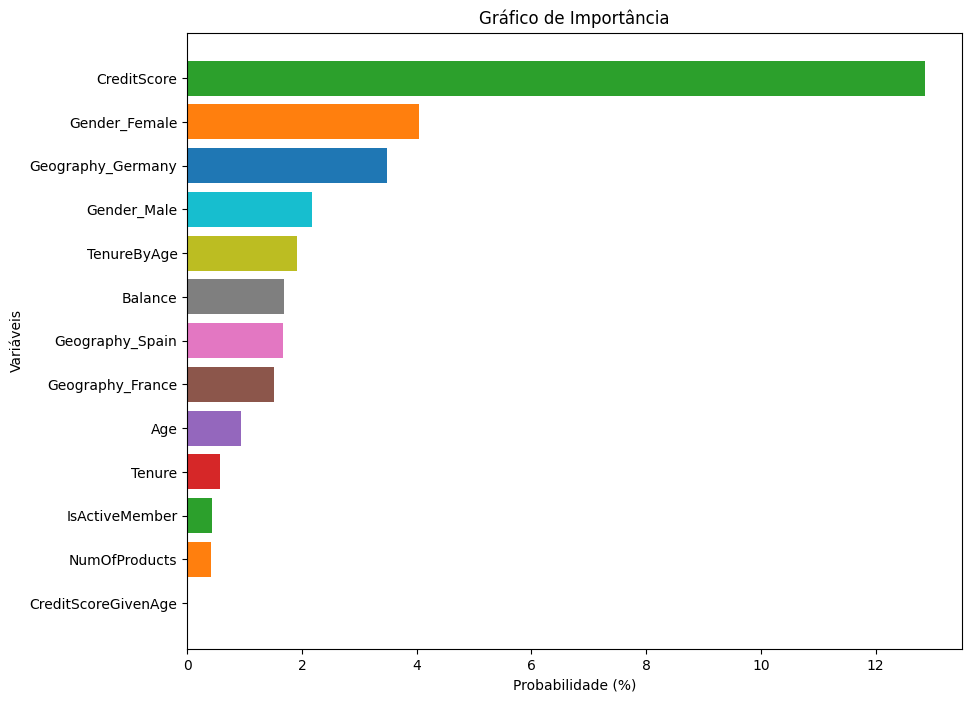

In [27]:
coefficients = pd.DataFrame(odds, X.columns, columns=['coef']).sort_values(by='coef', ascending=True)

plt.figure(figsize=(10,8))
plt.barh(coefficients.index, coefficients['coef'], color=['C{}'.format(i) for i in range(len(coefficients))])
plt.xlabel('Probabilidade (%)')
plt.ylabel('Variáveis')
plt.title('Gráfico de Importância')
plt.show()

In [28]:
logreg = LogisticRegression()
logreg.fit(X_t, y_t)

LogisticRegression()

In [29]:
y_pred = logreg.predict(X_t)
print('Acurácia do Modelo na Base de Teste: {:.2f}'.format(logreg.score(X_test, y_test)))

Acurácia do Modelo na Base de Teste: 0.82


In [30]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[2306   73]
 [ 474  147]]


In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      2379
           1       0.67      0.24      0.35       621

    accuracy                           0.82      3000
   macro avg       0.75      0.60      0.62      3000
weighted avg       0.80      0.82      0.78      3000



<Figure size 640x480 with 0 Axes>

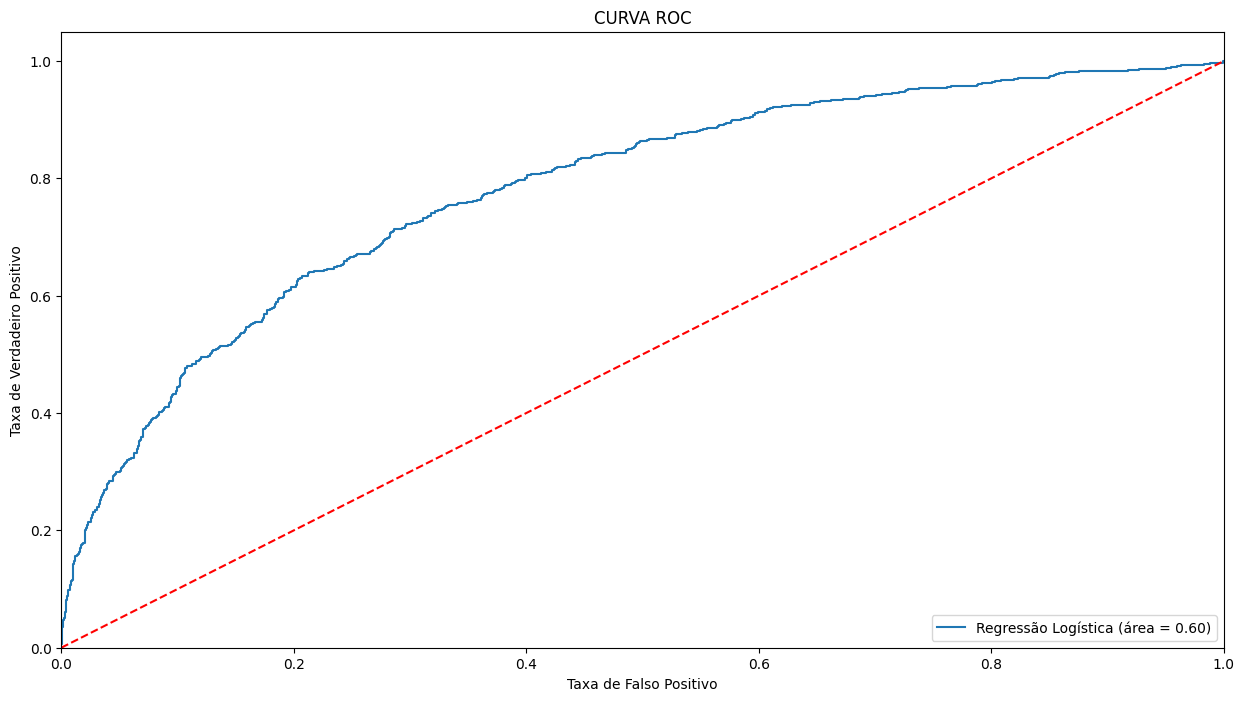

In [32]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_t, logreg.predict(X_t))
fpr, tpr, thresholds = roc_curve(y_t, logreg.predict_proba(X_t)[:,1])
plt.figure()
plt.figure(figsize=(15,8))
plt.plot(fpr, tpr, label='Regressão Logística (área = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('CURVA ROC')
plt.legend(loc="lower right")
plt.show()